<a href="https://colab.research.google.com/github/HabibaY/Analysis-of-Bank-Debit-Collections/blob/main/Bank_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
df = pd.read_csv('bank_data.csv')

In [6]:
#.sample(10) outputs randomly 10 records
df.sample(10)

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
1078,138,2422,2408.008447,Level 2 Recovery,47,Male
874,765,1911,2900.715251,Level 1 Recovery,33,Male
1677,187,5504,7767.461198,Level 4 Recovery,71,Male
984,816,2168,2235.182872,Level 2 Recovery,29,Male
615,853,1473,1871.546755,Level 1 Recovery,20,Female
335,1637,1092,1028.513414,Level 1 Recovery,19,Male
150,893,891,487.250000,Level 0 Recovery,24,Female
1273,276,3061,4440.961914,Level 3 Recovery,35,Female
177,1257,920,500.230000,Level 0 Recovery,27,Male
294,578,1056,846.203829,Level 1 Recovery,23,Female


Regression discontinuity: banking recovery
individuals or units are assigned to a treatment group or a control group based on a cutoff score or threshold of a continuous variable.
this threshold is:
Level 0: Expected recovery amounts >$0 and <=$1000
Level 1: Expected recovery amounts >$1000 and <=$2000
The threshold of $1000 separates Level 0 from Level 1

The basic idea is that individuals just above or below the cutoff are similar in all aspects except for their treatment status. By comparing the outcomes of individuals on either side of the cutoff, researchers can estimate the causal effect of the treatment.

we examine different columns vs the Expected Recovery amount column to see if there is a jump at $1000


Age vs Expected Recovery amount

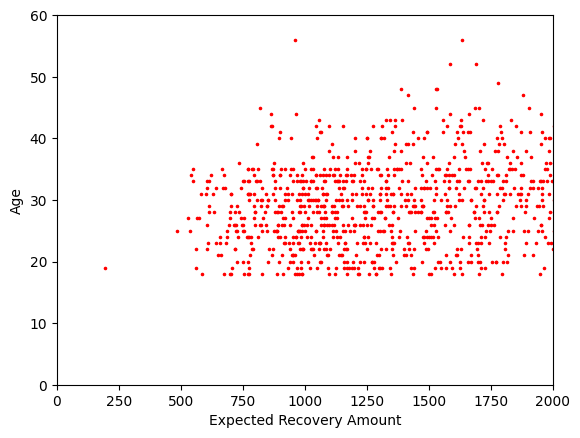

In [7]:
# Scatter plot of Age vs. Expected Recovery Amount
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="r", s=2.5)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
#plt.legend(loc=2)
plt.show()

Clearly there is no jump, there is no change before and after the $1000 amount. So, age is not dependent on the Expected Recovery amount

Sex vs Expected Recovery Amount

In [8]:
#Import stats module
from scipy import stats
#store the values in the expected recovery amount column which are >=900 and <1100
a=df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]
by_recovery_strategy = a.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_age = a.loc[df['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_age = a.loc[df['recovery_strategy']=="Level 1 Recovery"]['age']
stats.kruskal(Level_0_age,Level_1_age)

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

the pvalue is above the standard significant level(0.05) which means that we do not have sufficient evidence to reject the null hypothesis, which suggests that there is no statistically significant difference in the ages just above and below the threshold.

Statistical test: sex vs. expected recovery amount

In [9]:
# Number of customers in each category
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) &
                              (df['expected_recovery_amount']>=900)]['recovery_strategy'],
                       df['sex'])
print(crosstab)

# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print("pvalue = ",p_val)

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55
pvalue =  0.5377947810444592


the pvalue is above the standard significant level(0.05) which means that we do not have sufficient evidence to reject the null hypothesis, which suggests that there is no statistically significant difference in the ages just above and below the threshold

Exploratory graphical analysis: recovery amount

Text(0, 0.5, 'Expected Recovery Amount')

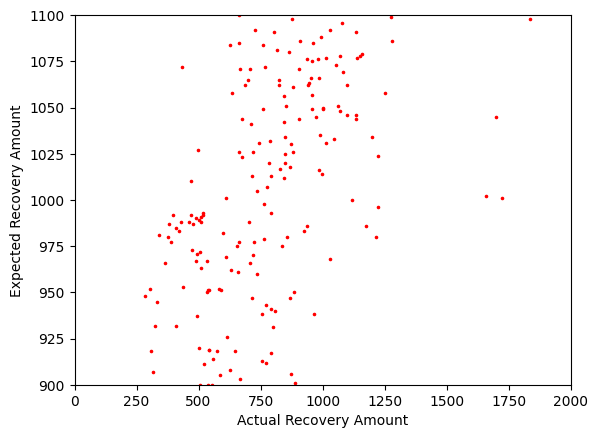

In [10]:
# Scatter plot of Actual Recovery Amount vs. Expected Recovery Amount
plt.scatter(x=df['actual_recovery_amount'], y=df['expected_recovery_amount'], c="r", s=2.5)
plt.ylim(900, 1100)
plt.xlim(0, 2000)
plt.xlabel("Actual Recovery Amount")
plt.ylabel("Expected Recovery Amount")



Statistical Analysis


For range between $900 and $1100

In [11]:
# Compute average actual recovery amount just below and above the threshold
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = a.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = a.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
stats.kruskal(Level_0_actual,Level_1_actual)

KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)

For range between $950 and $1050

In [12]:
b=df.loc[(df['expected_recovery_amount']<1050) &
                      (df['expected_recovery_amount']>=950)]

by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = b.loc[df['recovery_strategy']=="Level 0 Recovery"]['actual_recovery_amount']
Level_1_actual = b.loc[df['recovery_strategy']=="Level 1 Recovery"]['actual_recovery_amount']
stats.kruskal(Level_0_actual,Level_1_actual)

KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)

Comment: the 2 pvalues of the 2 ranges are below the standard significant level(0.05) which suggests that there is a statistically significant difference in the ages just above and below the threshold

Regression modeling: no threshold

To make regression models there are many approaches to be used;for example, scikit-learn, statsmodels libraries. However,scikit-learn is more oriented towards machine learning and offers a wide range of algorithms for regression tasks. So, statsmodels is more convinient as it is more focused on statistical analysis and provides detailed outputs.

WE will use simple linear regression technique as it works with no threshold and when there is only 1 predictor variable and 1 outcome variable.

In [26]:
# Import statsmodels
# import statsmodels.api as sm
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
# # Split the data into training and testing sets
# #input is expected_recovery_amount
# #output is actual_recovery_amount

# X_train, X_test, y_train, y_test = train_test_split(df['expected_recovery_amount'], df['actual_recovery_amount'], test_size=0.2, random_state=42)
# # Add a constant term to the independent variable (for intercept in the model)
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)
# # Create and fit the linear regression model using statsmodels
# model = sm.OLS(y_train, X_train).fit()  # Ordinary Least Squares
# #result = model.fit()
# Print the summary of the model
# print(model.summary())

# Make predictions on the test data
# y_pred = model.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R-squared: {r2}")


In [18]:
# Import statsmodels
import statsmodels.api as sm

# Define X and y
X = a['expected_recovery_amount']
y = a['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Thu, 20 Jul 2023   Prob (F-statistic):           1.56e-13
Time:                            20:47:18   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Thu, 20 Jul 2023   Prob (F-statistic):           1.56e-13
Time:                            21:14:35   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

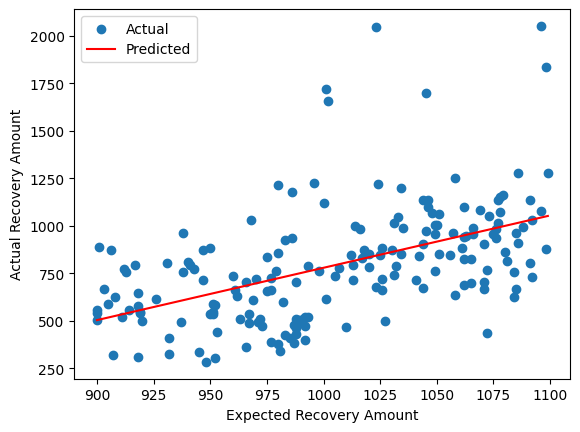

Mean Squared Error: 68806.51675613894
R-squared: 0.26055416614656135


In [22]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define X and y
X = a['expected_recovery_amount']
y = a['actual_recovery_amount']

# Add a constant term to the independent variable (for intercept in the model)
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
print(model.summary())

# Visualize the data and the regression line
plt.scatter(X['expected_recovery_amount'], y, label='Actual')
plt.plot(X['expected_recovery_amount'], predictions, color='red', label='Predicted')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.legend()
plt.show()

# Evaluate the model
#mse = ((y - predictions) ** 2).mean()
r2 = model.rsquared

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


An R-squared value of 0.261 indicates that approximately 26.1% of the variance in the actual recovery amount (y) is explained by the linear regression model using the expected recovery amount (X['expected_recovery_amount']) as the predictor. In other words, the model accounts for about 26.1% of the variability in the actual recovery amounts based on the variation in the expected recovery amounts.
A higher R-squared value closer to 1.0 indicates that the model explains a larger proportion of the variance in the dependent variable, suggesting a better fit to the data. However, a value of 1.0 is not always achievable or desirable as it may indicate overfitting.
A lower R-squared value, like the one in this case (0.261), indicates that the model does not explain much of the variance in the dependent variable. It suggests that other factors or variables not included in the model might be influencing the actual recovery amounts.

A positive coefficient like 2.7577 indicates a positive relationship between the expected_recovery_amount and the predicted actual_recovery_amount. As the expected recovery amount increases, the model predicts that the actual recovery amount will also increase.
The coefficient's magnitude (2.7577) suggests that the expected recovery amount has a moderate effect on predicting the actual recovery amount in this linear regression model.

Regression modeling: adding true threshold

The second model adds an indicator of the true threshold to the model. If there was no impact of the higher recovery strategy on the actual recovery amount, then we would expect that the relationship between the expected recovery amount and the actual recovery amount would be continuous.

<ipython-input-24-efc7a1921060>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['above_threshold'] = (a['expected_recovery_amount'] >= 1000).astype(int)


                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Thu, 20 Jul 2023   Prob (F-statistic):           1.83e-15
Time:                            21:34:58   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

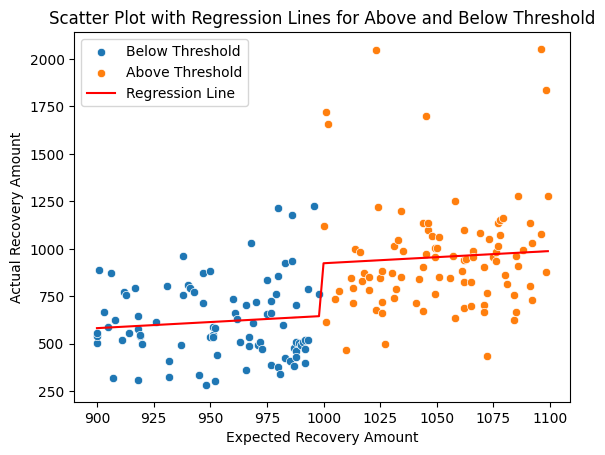

In [24]:
#Create a binary variable 'above_threshold'
a['above_threshold'] = (a['expected_recovery_amount'] >= 1000).astype(int)

#Define X and y for the second model
X_second = a[['expected_recovery_amount', 'above_threshold']]
y_second = a['actual_recovery_amount']

#Add a constant to X for the intercept term
X_second = sm.add_constant(X_second)

#Build the second linear regression model
model_second = sm.OLS(y_second, X_second).fit()

#Print out the model summary statistics
print(model_second.summary())

import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with regression line for below_threshold
sns.scatterplot(x='expected_recovery_amount', y='actual_recovery_amount', data=a[a['above_threshold'] == 0], label='Below Threshold')

# Scatter plot with regression line for above_threshold
sns.scatterplot(x='expected_recovery_amount', y='actual_recovery_amount', data=a[a['above_threshold'] == 1], label='Above Threshold')

# Regression lines for both groups
sns.lineplot(x='expected_recovery_amount', y=model_second.predict(X_second), data=a, color='red', label='Regression Line')

plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.legend()
plt.title('Scatter Plot with Regression Lines for Above and Below Threshold')
plt.show()





Here we can see that the coef for the indicator is statistically significant (p-value<0.05) ,it indicates that the relationship between the expected recovery amount and the actual recovery amount is different between the two groups (above and below the threshold).

The coefficient for the 'above_threshold variable' is statistically significant, suggesting that the higher recovery strategy (above the threshold) has a significant impact on the actual recovery amount. Specifically, when the expected recovery amount is above the threshold, the model predicts that the actual recovery amount will increase by approximately 277.63 units compared to when it is below the threshold.

However, a positive coefficient (0.6430) indicates a positive relationship between the 'expected_recovery_amount' and the predicted 'actual_recovery_amount.' As the expected recovery amount increases, the model predicts that the actual recovery amount will also increase.
The magnitude of the coefficient (0.6430) indicates that for every one-unit increase in the 'expected_recovery_amount,' the model predicts an increase of approximately 0.6430 units in the 'actual_recovery_amount.' However, since this coefficient is not statistically significant (as indicated by the high p-value of 0.328), the confidence in the magnitude's accuracy is low.


The values [0.025 0.975] associated with the 'above_threshold' coefficient represent the confidence interval for the coefficient estimate. The confidence interval provides a range of values within which the true population coefficient is likely to lie with a certain level of confidence.

In the provided example, the 95% confidence interval for the 'above_threshold' coefficient is [131.530, 423.739]. This means that we are 95% confident that the true population coefficient lies between 131.530 and 423.739.
The interval [131.530, 423.739] suggests that the true effect of the 'above_threshold' variable on the 'actual_recovery_amount' could be anywhere within this range. The coefficient value of 277.6344 is the best point estimate, but the true value may be as low as 131.530 or as high as 423.739.
Interpreting the confidence interval helps us understand the uncertainty associated with the coefficient estimate. It provides a range of values within which we believe the true population coefficient lies based on the sample data

Regression modeling: adjusting the window

Before showing this to our managers, we want to convince ourselves that this result wasn't due just to us choosing a window of $900 to $1100 for the expected recovery amount. If the higher recovery strategy really had an impact of an extra few hundred dollars, then we should see a similar regression coefficient if we choose a slightly bigger or a slightly smaller window for the expected recovery amount. Let's repeat this analysis for the window of expected recovery amount from $950 to $1050 to see if we get similar results.

In [25]:
#Create a binary variable 'above_threshold'
b['above_threshold'] = (b['expected_recovery_amount'] >= 1000).astype(int)

#Define X and y for the second model
X_second = a[['expected_recovery_amount', 'above_threshold']]
y_second = a['actual_recovery_amount']

#Add a constant to X for the intercept term
X_second = sm.add_constant(X_second)

#Build the second linear regression model
model_second = sm.OLS(y_second, X_second).fit()

#Print out the model summary statistics
print(model_second.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Thu, 20 Jul 2023   Prob (F-statistic):           1.83e-15
Time:                            22:08:13   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

<ipython-input-25-2d8f7708ddae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['above_threshold'] = (b['expected_recovery_amount'] >= 1000).astype(int)


Here shows that changing the window doesn't change the regression coefficient, it is still significant and the estimated impact is similar to the previous window. So we can conclude that the higher recovery strategy has a meaningful impact on the actual recovery amount for customers just above and just below the threshold.